# 4th Notebook for Machine Learning Intro Lecture

## 1. Data dependent CARTS

Classification and decision trees are very powerful but do have on major drawback: they are highly data-dependent. We show this with the following example on the __servo__ data set that offers a regression task and looks like that:

In [4]:
# load tons of packages
library(rpart)
library(dplyr)
library(rattle)
library(mlbench)
library(methods)
library(devtools)
library(BBmisc)
library(RWeka)
library(rpart.plot)
library(partykit)
library(ggplot2)
library(mlr)
library(randomForest)


data("Servo")

# transform ordered factors to numeric
servo = Servo %>% 
  mutate_at(c("Pgain", "Vgain"), as.character) %>%
  mutate_at(c("Pgain", "Vgain"), as.numeric)
rm(Servo)
str(servo)
head(servo)

ERROR: Error in library(rattle): there is no package called ‘rattle’


We fit two CART's on our data which we split in train and test at two different seeds, resulting in slightly different train and test data sets. 

Check the differencies in the CART architecture that was induced by those differing seeds: 

In [3]:
# split in train and test with two different seeds to show data dependency
trainSize = 3/4

set.seed(1333)
trainIndices = sample(x = seq(1, nrow(servo), by = 1), 
  size = ceiling(trainSize * nrow(servo)), replace = FALSE)
train1 = servo[ trainIndices, ]
test1 = servo[ -trainIndices, ]

set.seed(1)
trainIndices = sample(x = seq(1, nrow(servo), by = 1), 
  size = ceiling(trainSize * nrow(servo)), replace = FALSE)
train2 = servo[ trainIndices, ]
test2 = servo[ -trainIndices, ]


model1 = rpart(Class ~., data = train1)
rattle::fancyRpartPlot(model1, palettes = "Oranges", main = "CART from split 1", sub = "")


model2 = rpart(Class ~., data = train2)
rattle::fancyRpartPlot(model2, palettes = "Blues", main = "CART from split 2", sub = "")

ERROR: Error in nrow(servo): Objekt 'servo' nicht gefunden


* Why is that a problem? Don't we want a data dependent algorithm?
* What can we do to address this issue?

## 2. Understanding the Hyperparameters of CARTS

#### Min split:

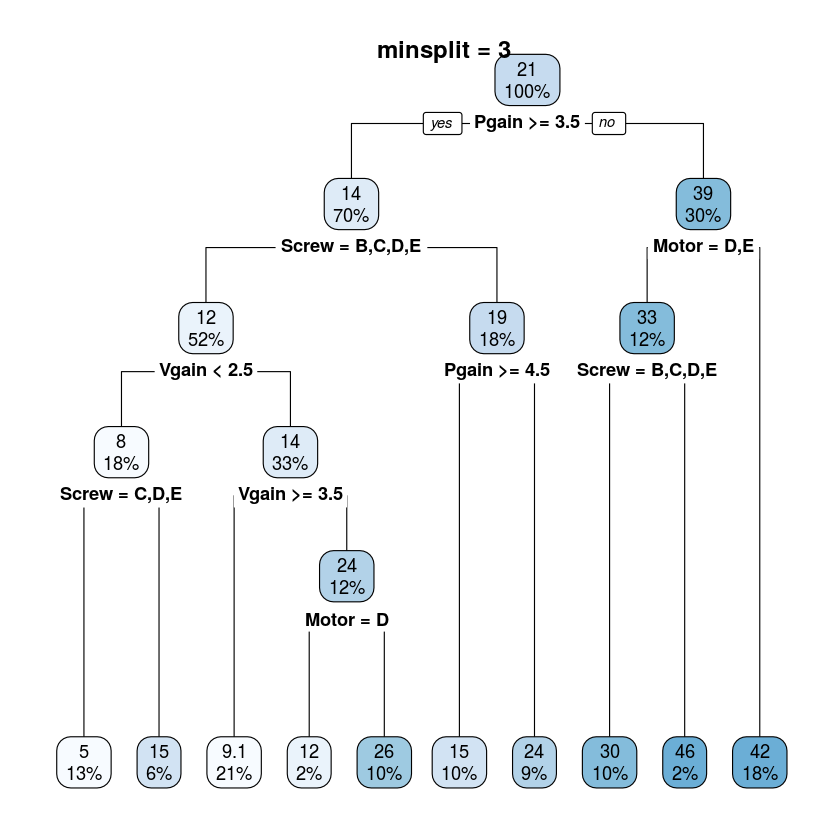

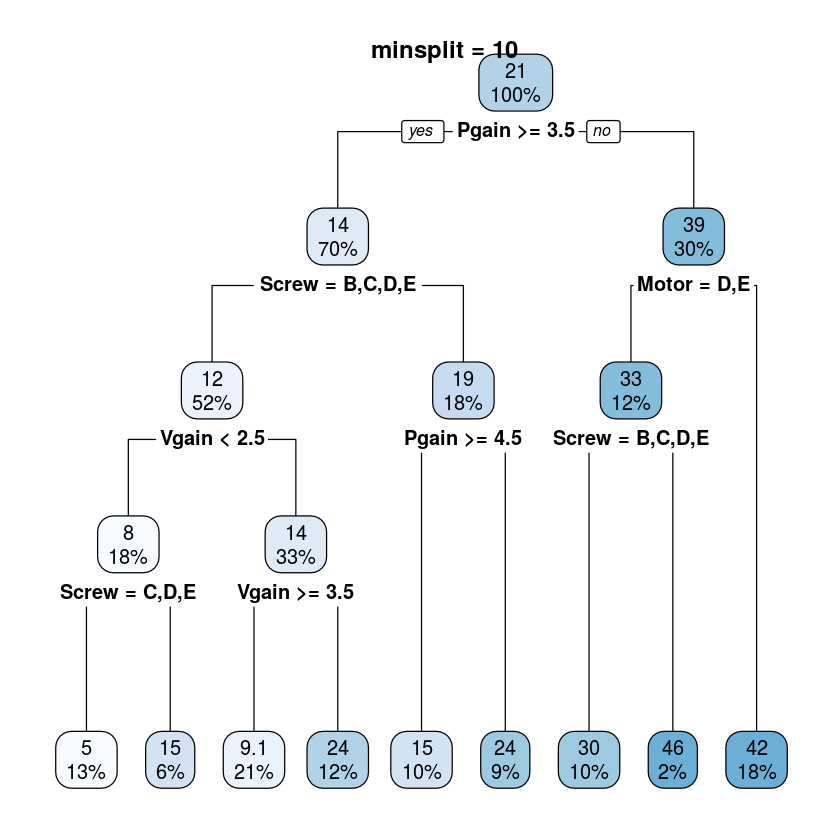

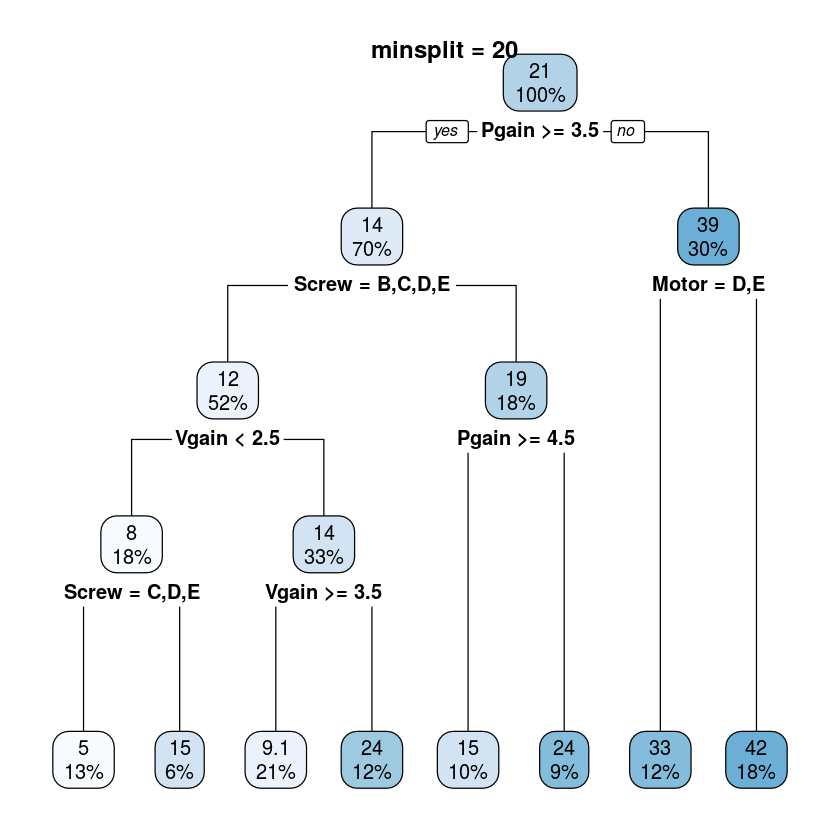

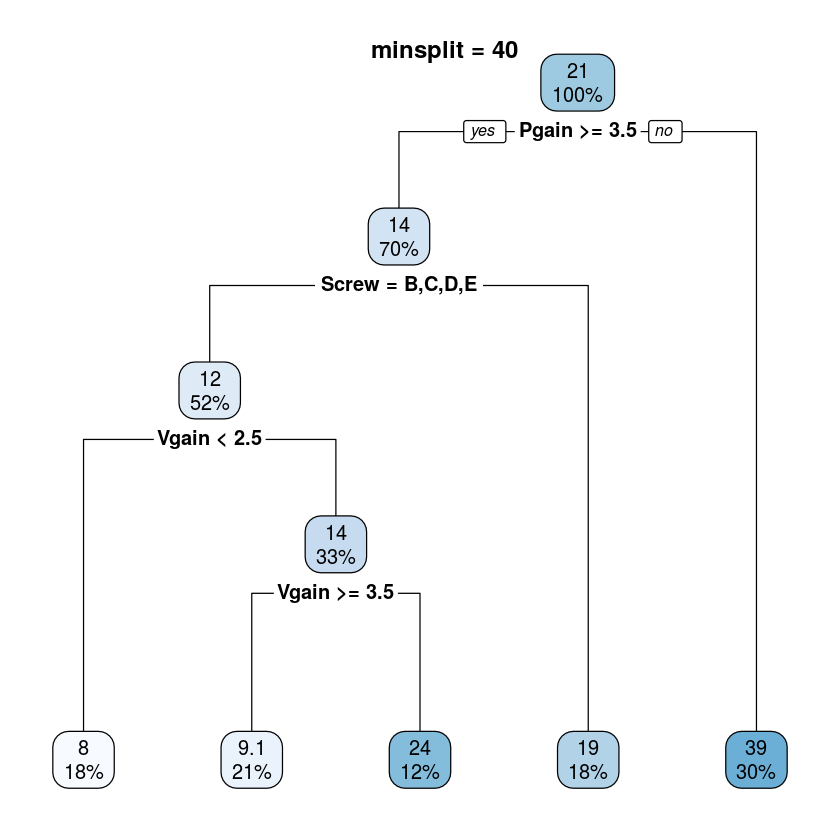

In [44]:

task = makeRegrTask(data = train1, target = "Class")
lrn1 = makeLearner("regr.rpart")

plotParamSequence = function(learner, task, param, values, plotfun, ...) {
  for (v in values) {
    xs = list(...)
    xs[[param]] = v
    lrn2= setHyperPars(learner, par.vals = xs)
    mod = mlr::train(lrn2, task)
    plotfun(mod$learner.model)
    title(sprintf("%s = %g", param, v))
    pause()
  }
}

plotParamSequenceRPart = function(...) plotParamSequence(learner = lrn1, plotfun = rpart.plot, ...)

minsplits = c(3, 10, 20, 40)
plotParamSequenceRPart(task = task, param = "minsplit", values = minsplits)




Maximum depth of the tree

In [1]:
task = makeRegrTask(data = train1, target = "Class")
lrn1 = makeLearner("regr.rpart")

plotParamSequence = function(learner, task, param, values, plotfun, ...) {
  for (v in values) {
    xs = list(...)
    xs[[param]] = v
    lrn2= setHyperPars(learner, par.vals = xs)
    mod = mlr::train(lrn2, task)
    plotfun(mod$learner.model)
    title(sprintf("%s = %g", param, v))
    pause()
  }
}

plotParamSequenceRPart = function(...) plotParamSequence(learner = lrn1, plotfun = rpart.plot, ...)

maxdepth  = c(1, 4, 10)
plotParamSequenceRPart(task = task, param = "maxdepth", values = maxdepth)

ERROR: Error in makeRegrTask(data = train1, target = "Class"): konnte Funktion "makeRegrTask" nicht finden


## 3. Invariance to monotonous feature transformation


Nice thing about the CARTs is, that they are invariant to scaling and other monotonous feature transformations. 

We grow two trees on two dataset, which only differ in the fact, that the numeric features in the second data set are log-transformed. 

Let's see, how the architecture of the two CARTs differs (or not)!


Motor,Screw,Pgain,Vgain,Class
A,E,1.386294,0.0000000,3
E,C,1.386294,1.0986123,20
E,C,1.098612,0.6931472,35


,Motor,Screw,Pgain,Vgain,Class
95,A,E,4,1,3
6,E,C,4,3,20
146,E,C,3,2,35


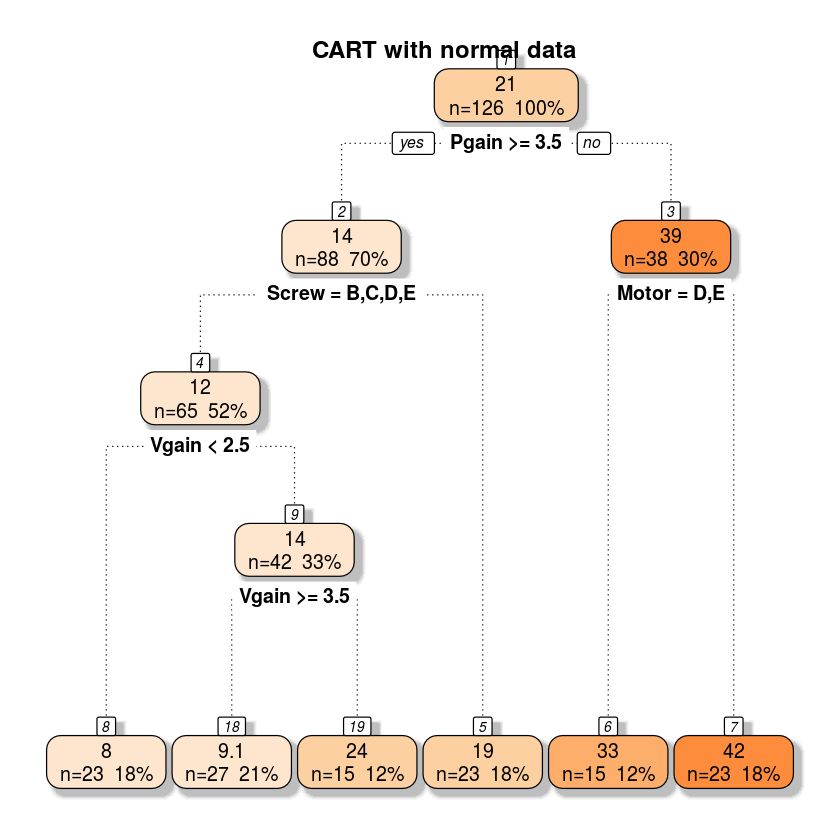

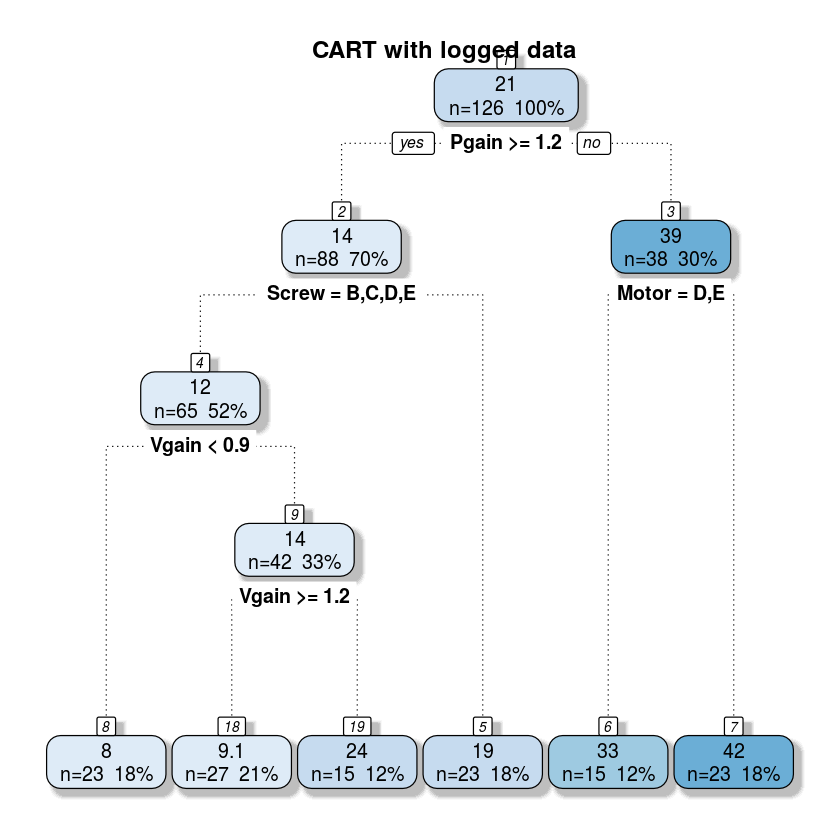

In [46]:
trainlog = train1 %>% mutate_at(c("Pgain", "Vgain"), log)
head(trainlog, 3)
head(train1, 3)

model1 = rpart(Class ~., data = train1, minsplit = 30)
rattle::fancyRpartPlot(model1, palettes = "Oranges", main = "CART with normal data", sub = "")


modellog = rpart(Class ~., data = trainlog, minsplit = 30)
rattle::fancyRpartPlot(modellog, palettes = "Blues", main = "CART with logged data", sub = "")

## 4. Random Forests and variable importance

#### Variable Importance from mlr

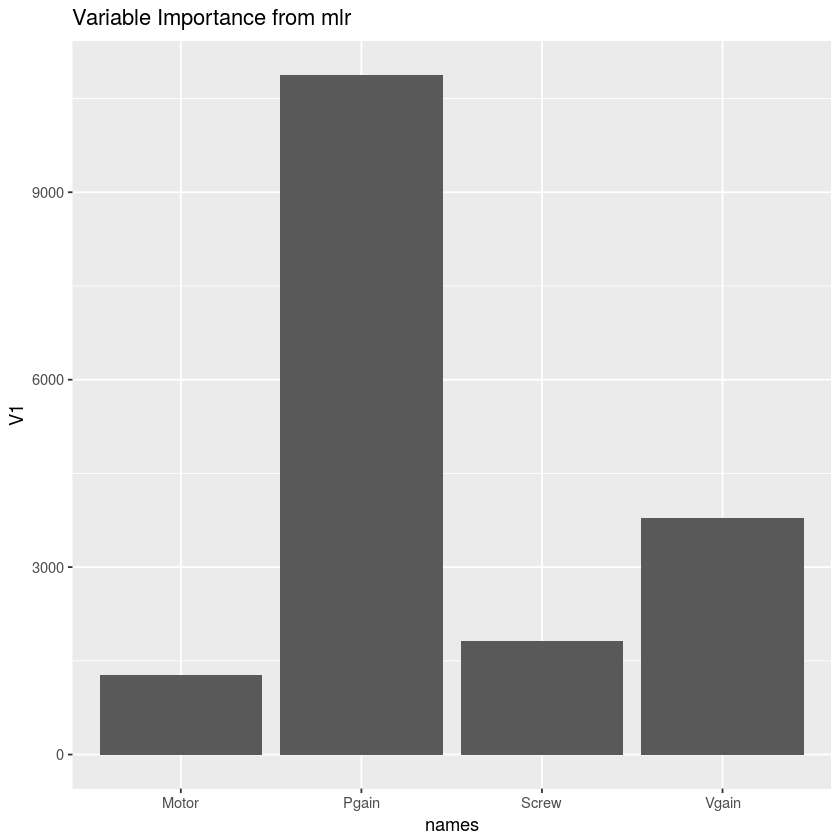

In [47]:
task = makeRegrTask(data = train1, target = "Class")
lrn1 = makeLearner("regr.randomForest")
mod = mlr::train(learner = lrn1, task = task)

varimp = getFeatureImportance(mod)
var = as.data.frame(t(varimp$res))
var$names = names(varimp$res)
p = ggplot(data = var, aes(x = names, y = V1)) + geom_bar(stat = "identity") +
    ggtitle(label = "Variable Importance from mlr")
p


#### Variable importance from partykit

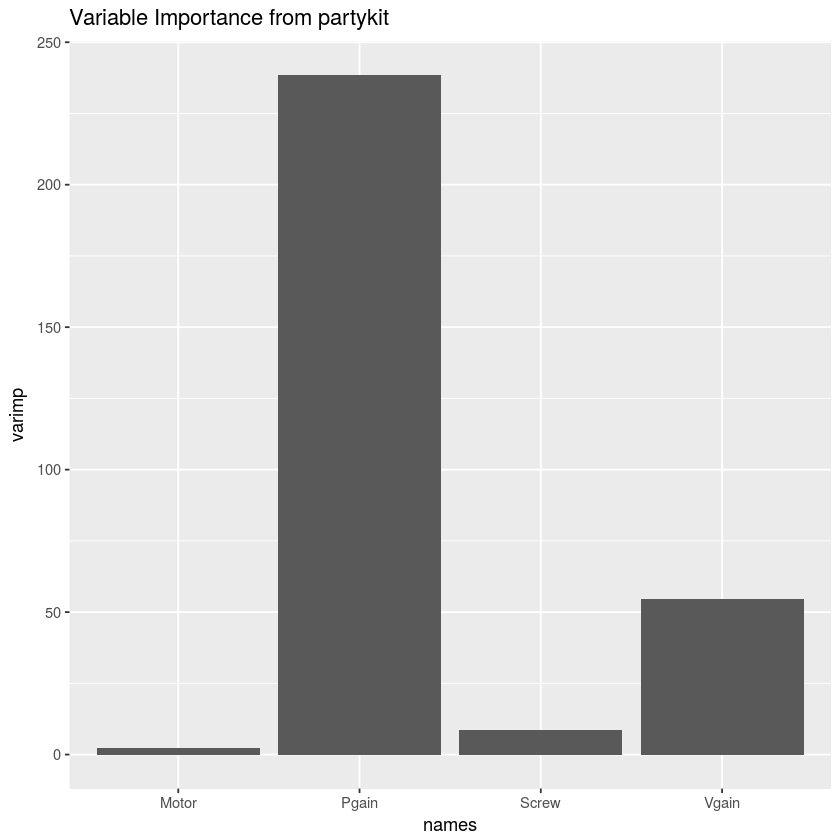

In [48]:
modForest = cforest(Class ~ Motor + Screw + Pgain + Vgain, data = train1)
var = as.data.frame(varimp(modForest))
var$names = rownames(var)
colnames(var) = c("varimp", "names")
p = ggplot(data = var, aes(x = names, y = varimp)) + 
    geom_bar(stat = "identity") + 
    ggtitle(label = "Variable Importance from partykit")
p

## 5. Proximity measures in Random Forests

One neat feature of random forests is, that they calculate proximity measures (how close is one data point to another) on the fly. Therefore, frequencies of the observations ending up in the same terminal node are being calculated and we can try to interpret them and do fancy stuff such as __multi dimensional scaling__. Check [this blog post](https://www.r-statistics.com/2016/01/multidimensional-scaling-with-r-from-mastering-data-analysis-with-r/) for a wonderful example with European Capital Cities.

We apply this to our spiral data set and try to see, if we could also classifiy the points based on their proximity. 

First, look a the data:

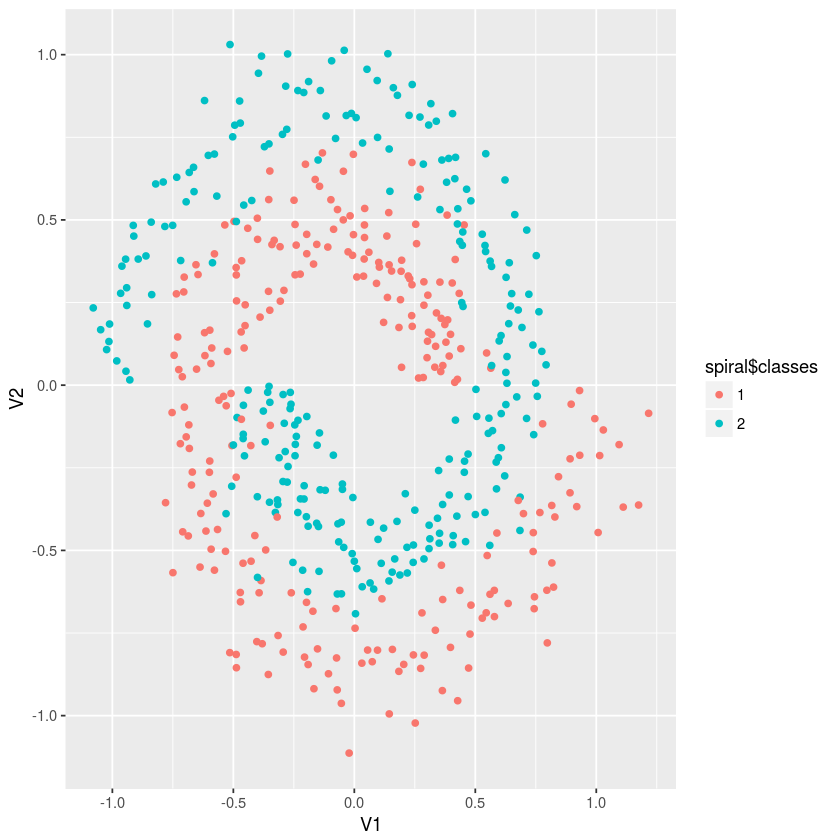

In [49]:
# get data
spiral = mlbench::mlbench.spirals(500, cycles = 1, sd = 0.1)
p = ggplot(data = as.data.frame(spiral$x), aes(x = V1, y = V2, colour = spiral$classes)) +
  geom_point()
p


Now we fit a random forest and extract the proximity distance matrix:


In [60]:
# fit forest and extract proximity measure
set.seed(1337)
modProx = randomForest(x = spiral$x, y = spiral$classes, proximity = TRUE, oob.prox = TRUE)
proxMat = modProx$proximity
proxMat[1:5, 1:5]

1,0.00000000,0.00000000,0,0.00000000
0,1.00000000,0.04347826,0,0.93670886
0,0.04347826,1.00000000,0,0.04285714
0,0.00000000,0.00000000,1,0.00000000
0,0.93670886,0.04285714,0,1.00000000


Run mds on it and plot the data based on the two dimensions:

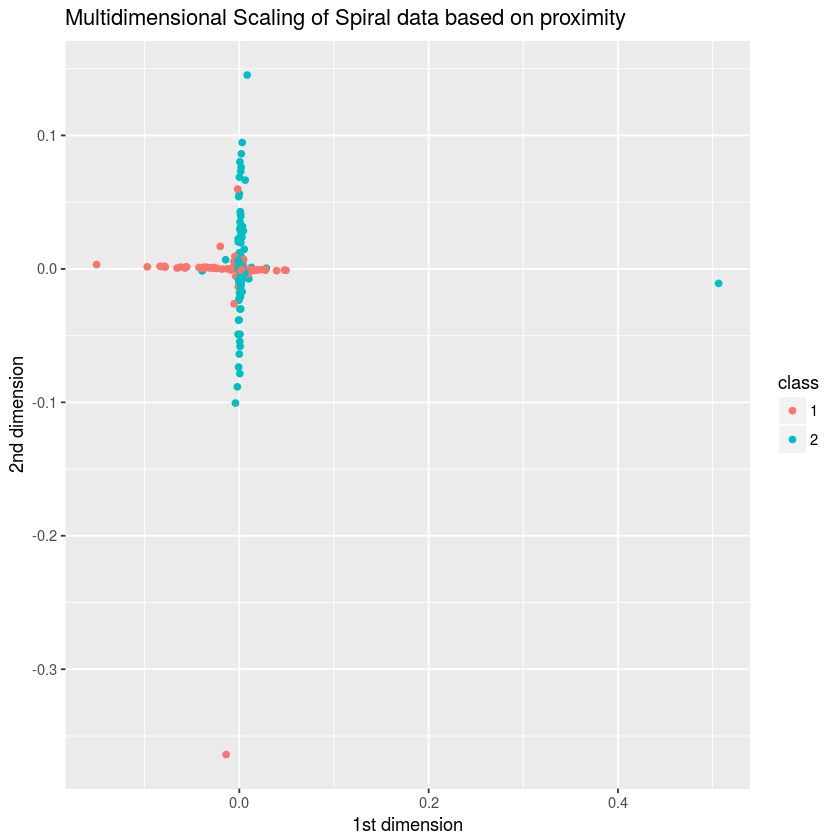

In [61]:
# apply mds on the proximity matrix
mds = as.data.frame(cmdscale(proxMat))
mds$class = spiral$classes

# plot the result, sweet
p = ggplot(data = mds, aes(x = V1, y = V2, colour = class)) +
  geom_point() +
  labs(x = "1st dimension", y = "2nd dimension", title = "Multidimensional Scaling of Spiral data based on proximity")
p

## 6. Decision Regions CART vs. Random Forest

Decision regions for the CART:

Loading required package: ParamHelpers


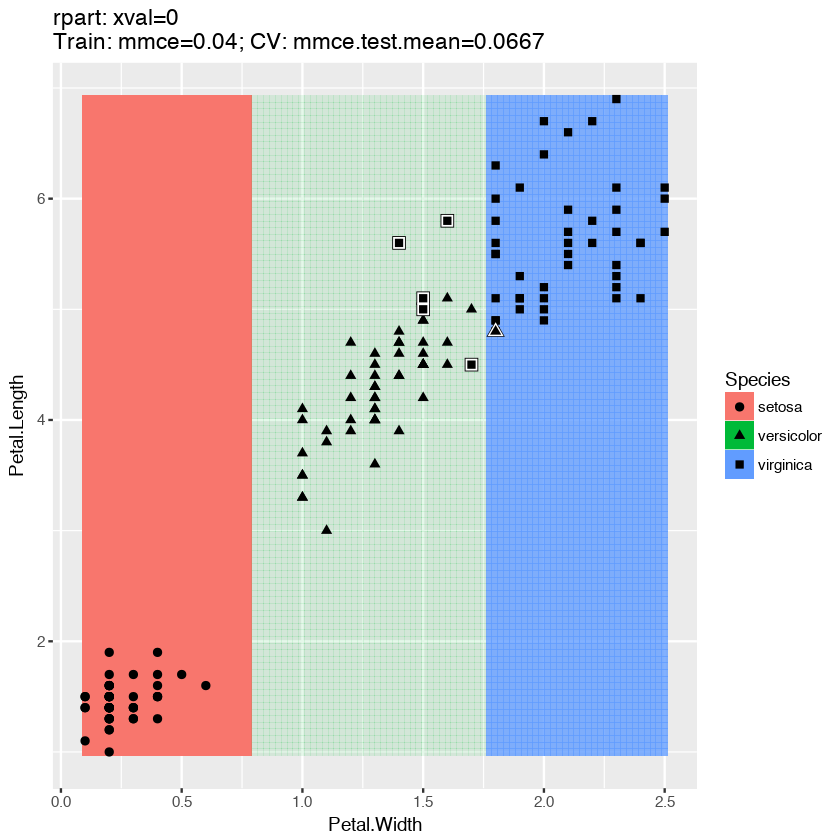

In [9]:
library(mlr)
# get data
data("iris")
# set features that should be inspected within the regions
features = c("Petal.Width", "Petal.Length")

task = mlr::makeClassifTask(data = iris, target = "Species")

mlr::plotLearnerPrediction(learner = "classif.rpart", task = task, 
    features = features)

Decision regions for the Random Forest:

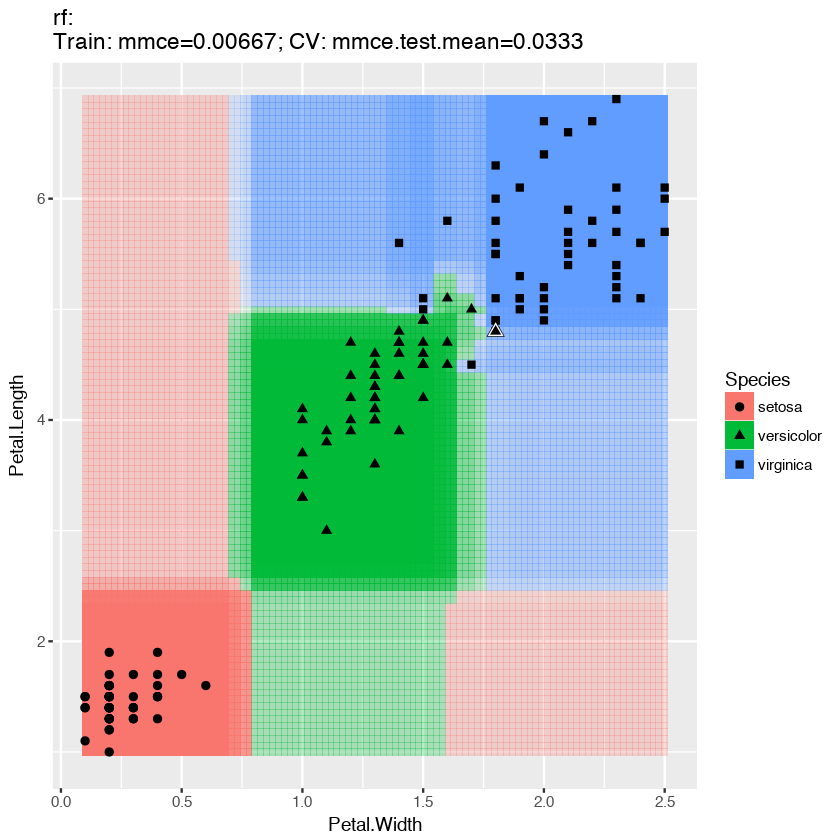

In [11]:
mlr::plotLearnerPrediction(learner = "classif.randomForest", task = task, 
    features = features)